<a href="https://colab.research.google.com/github/ayulockin/deepimageimpainting/blob/master/Image_Inpainting_Autoencoder_decoder_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

print(tf.config.list_physical_devices('GPU'))


2023-03-21 21:21:15.502220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 21:21:15.692304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 21:21:15.692353: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-21 21:21:15.735238: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023

2.10.0
[]


2023-03-21 21:21:19.093627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 21:21:19.093855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 21:21:19.093992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 21:21:19.094139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

In [2]:
import os
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

n_epochs = 1
img_x,img_y = 32,32

# Prepare Dataset

In [3]:
# loadedImg1 = np.load('../coco/train_npy/np_images_train_20000_30000.npy').astype(int)
# print("Loaded 1")
# loadedImg2 = np.load('../coco/train_npy/np_images_train_30000_40000.npy').astype(int)
# print("Loaded 2")
# loadedImg3 = np.load('../coco/train_npy/np_images_train_40000_50000.npy').astype(int)
# print("Loaded 3")
# loadedImg4 = np.load('../coco/train_npy/np_images_train_50000_60000.npy').astype(int)
# print("Loaded 4")
# loadedImg5 = np.load('../coco/train_npy/np_images_train_60000_70000.npy').astype(int)
# print("Loaded 5")
# loadedImg6 = np.load('../coco/train_npy/np_images_train_70000_80000.npy').astype(int)
# print("Loaded All")
# loadedImg = np.vstack([loadedImg1, loadedImg2, loadedImg3, loadedImg4, loadedImg5, loadedImg6]).astype(np.uint8)

In [4]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# (x_train2, y_train2), (x_test2, y_test2) = keras.datasets.cifar10.load_data()

# if loadedImg.shape[1] != img_x:
#     resizedImg = np.zeros((loadedImg.shape[0],img_x,img_y,3))
#     for i in range(loadedImg.shape[0]):
#         if i % 1000 == 0: print(i)
#         img = Image.fromarray(loadedImg[i])
#         resizedImg[i] = np.array(img.resize((img_x,img_y)))
# else: resizedImg = loadedImg
        
# x_train = resizedImg[:-5000].astype(int)
# x_test = resizedImg[-5000:].astype(int)



x_train shape: (54895, 32, 32, 3)
x_test shape: (5000, 32, 32, 3)
54895 train samples
5000 test samples


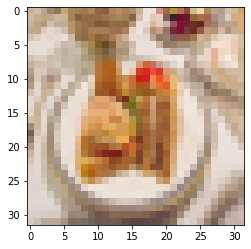

In [5]:
# np.save("../coco/train_total_3232.npy", x_train)
# np.save("../coco/test_total_3232.npy", x_test)
x_train = np.load("../coco/train_total_3232.npy")
x_test = np.load("../coco/test_total_3232.npy")
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
plt.imshow(x_test[170])

#### Visualization of Cifar 10

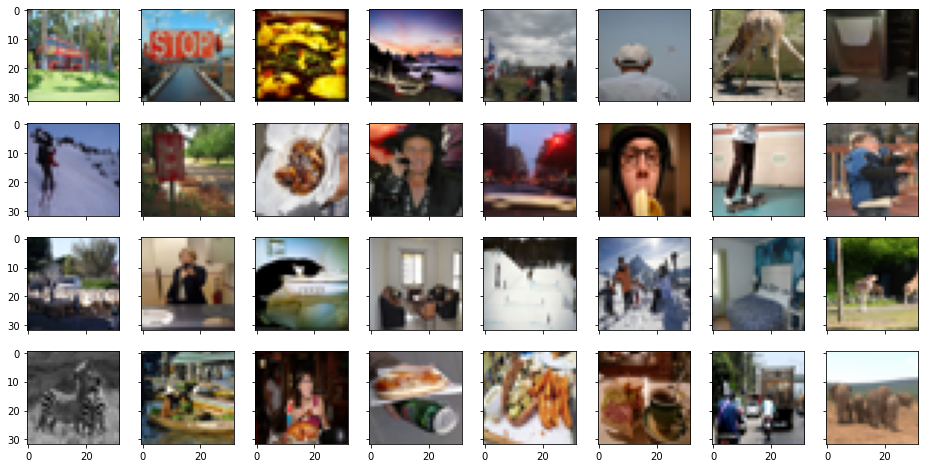

In [6]:
sample_images = x_train[:32]
# sample_labels = y_train[:32]
# sample_images = x_train[:x_train.shape[1]]
# sample_labels = y_train[:x_train.shape[1]]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

# for ax, image, label in zip(grid, sample_images, sample_labels):
for ax, image in zip(grid, sample_images):
  ax.imshow(image)
#   ax.set_title(label[0])

plt.show()

#### Data Generator with Patch Augmentation

In [7]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.y = y
      self.X = X
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
      X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
      y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))

#       x = y = np.random.randint(0, 31, 1)[0]
#       w = h = np.random.randint(1, 10, 1)[0]
      x = y = self.dim[1] // 2
      w = h = self.dim[1] // 8

      for i, idx in enumerate(idxs):
        tmp_image = self.X[idx].copy()

        mask = np.full(tmp_image.shape, 255, np.uint8)
        mask[y-h:y+h,x-w:x+w] = 0
        res = np.bitwise_and(tmp_image, mask)

        X_batch[i,] = res/255
        y_batch[i] = self.y[idx]/255
        
      return X_batch, y_batch

In [8]:
traingen = createAugment(x_train, x_train, dim=(img_x,img_y))
testgen = createAugment(x_test, x_test, dim=(img_x,img_y))

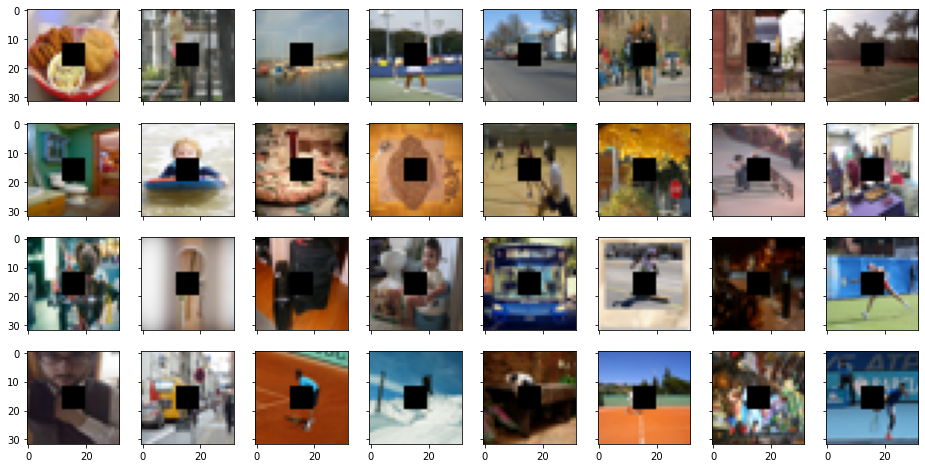

In [9]:
## Examples
sample_idx = 99 ## Change this to see different batches

sample_images, sample_labels = traingen[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

## Autoencoder-Decoder Model

In [10]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

In [11]:
def unet_like(input_x=32, input_y=32):
  inputs = keras.layers.Input((input_x, input_y, 3))
  conv1 = keras.layers.Conv2D(input_x, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = keras.layers.Conv2D(input_x, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = keras.layers.Conv2D(input_x*2, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = keras.layers.Conv2D(input_x*2, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = keras.layers.Conv2D(input_x*4, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = keras.layers.Conv2D(input_x*4, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = keras.layers.Conv2D(input_x*8, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = keras.layers.Conv2D(input_x*8, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
  conv5 = keras.layers.Conv2D(input_x*16, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = keras.layers.Conv2D(input_x*16, (3, 3), activation='relu', padding='same')(conv5)

  up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(input_x*8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
  conv6 = keras.layers.Conv2D(input_x*8, (3, 3), activation='relu', padding='same')(up6)
  conv6 = keras.layers.Conv2D(input_x*8, (3, 3), activation='relu', padding='same')(conv6)
  up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(input_x*4, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = keras.layers.Conv2D(input_x*4, (3, 3), activation='relu', padding='same')(up7)
  conv7 = keras.layers.Conv2D(input_x*4, (3, 3), activation='relu', padding='same')(conv7)
  up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(input_x*2, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = keras.layers.Conv2D(input_x*2, (3, 3), activation='relu', padding='same')(up8)
  conv8 = keras.layers.Conv2D(input_x*2, (3, 3), activation='relu', padding='same')(conv8)
  up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(input_x, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = keras.layers.Conv2D(input_x, (3, 3), activation='relu', padding='same')(up9)
  conv9 = keras.layers.Conv2D(input_x, (3, 3), activation='relu', padding='same')(conv9)
  conv10 = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

  return keras.models.Model(inputs=[inputs], outputs=[conv10])  


In [12]:
keras.backend.clear_session()
model = unet_like(img_x, img_y)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

2023-03-21 21:21:28.302484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

# Train

In [14]:
model.fit(traingen, validation_data=testgen, 
          epochs=n_epochs, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True)

1715/1715 [==============================] - 950s 553ms/step - loss: 0.5442 - dice_coef: 0.5826 - val_loss: 0.5409 - val_dice_coef: 0.5747


# Testing on images

In [19]:
model.save('models/impaint_coco3232_epch'+str(n_epochs)+'.h5')

1/1 [==============================] - 0s 371ms/step


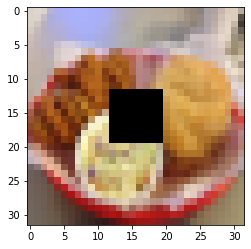

In [16]:
im = sample_images[0]
plt.imshow(im)
impainted_image = model.predict(im.reshape((1,)+im.shape))

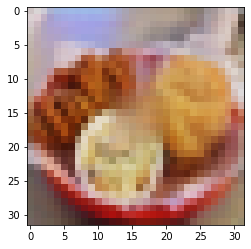

In [17]:
plt.imshow(impainted_image.reshape(impainted_image.shape[1:]))

1/1 [==============================] - 0s 34ms/step


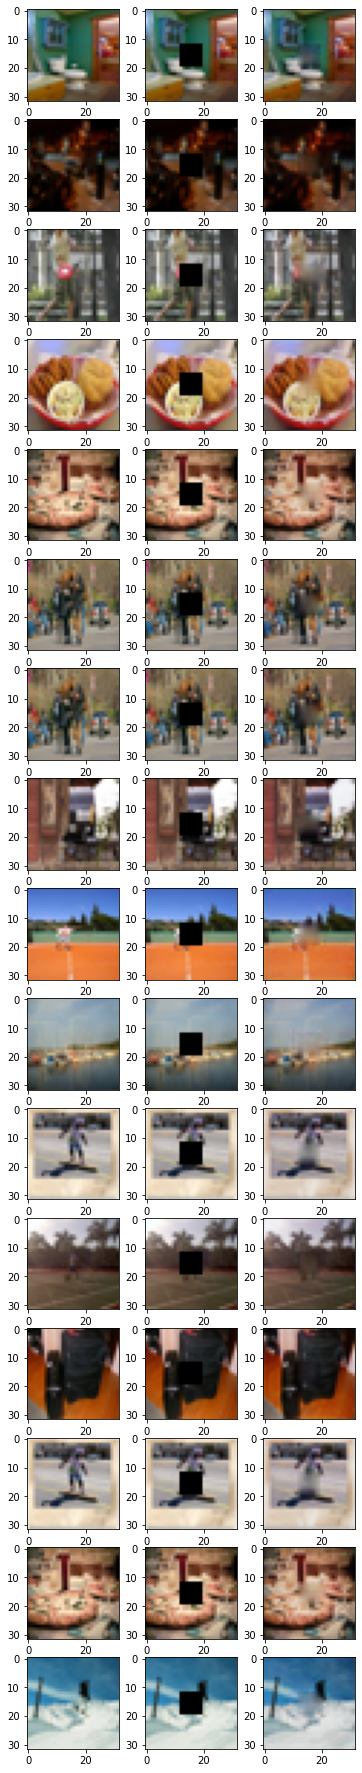

In [18]:
## Examples
rows = 16
sample_idx = np.random.randint(0, len(testgen), rows)

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 32))

for i, idx in enumerate(sample_idx):
#   sample_images, sample_labels = traingen[idx]
  img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
  impainted_image = model.predict(sample_images[img_idx].reshape((1,)+sample_images[img_idx].shape))
  axs[i][0].imshow(sample_labels[img_idx])
  axs[i][1].imshow(sample_images[img_idx])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()